In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import cv2
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import utils

### Getting Your data In

(48, 48, 3)


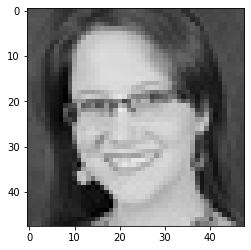

In [4]:
img_example = cv2.imread(r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Training\Happy\7.jpg')
img_example
print(img_example.shape)
plt.imshow(img_example);

In [5]:
train_images_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Training'
valid_images_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer_directory\Validation'

In [6]:
csv_path = r'D:\Satyajit\Code\Projects\Developing\Facial Expressions Classifier\face-expression-recognition-dataset\fer2013\fer2013.csv'

### Via Keras's ImageDataGeneratorClass

In [7]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)

In [8]:
aug_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)

In [9]:
# zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2

#### ImageDataGenerator Method 1:
`Flow From Directory`

In [ ]:
train_flow = train_gen.flow_from_directory(train_images_path, color_mode='grayscale', target_size=(48, 48))

In [ ]:
valid_flow = valid_gen.flow_from_directory(valid_images_path, color_mode='grayscale', target_size=(48, 48))

#### ImageDataGenerator Method 2:
`Flow (From Array)`

In [ ]:
df = pd.read_csv(csv_path)

In [ ]:
df.columns

In [ ]:
df.Usage.unique()

In [ ]:
df['pixels'] = df.pixels.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((48,48,1)))

In [ ]:
i = 7
print(df['emotion'][i])
array_to_img(df['pixels'][i].reshape((48,48,1)))

In [ ]:
def convert_to_array(s):
    arr = np.array(list(s)).reshape((-1,48,48,1))
    return arr

In [ ]:
cw = df[df.Usage=='Training'].emotion.value_counts()
class_weight_dict = dict(cw/sum(cw))

In [ ]:
def train_val_test_split(data):
    train = data[data.Usage=='Training']
    val = data[data.Usage=='PublicTest']
    test = data[data.Usage=='PrivateTest']
    x_train, y_train = train['pixels'], train['emotion']
    x_val, y_val = val['pixels'], val['emotion']
    x_test, y_test = test['pixels'], test['emotion']
    return convert_to_array(x_train), convert_to_array(x_val), convert_to_array(x_test), utils.to_categorical(y_train, num_classes=7),  utils.to_categorical(y_val, num_classes=7),  utils.to_categorical(y_test, num_classes=7)

In [ ]:
x_train, x_val, x_text, y_train, y_val, y_test = train_val_test_split(df)

In [ ]:
aug_gen.fit(x_train)

In [ ]:
Aug_flow = aug_gen.flow(x_train, y_train, batch_size=64)

In [ ]:
val_flow = valid_gen.flow(x_val, y_val, batch_size=64)

### Via OpenCV2 & OS module

In [ ]:
train_x, valid_x, train_y, valid_y = [], [], [], []

In [ ]:
classes = [category for category in os.listdir(train_images_path)]

In [ ]:
for category in os.listdir(train_images_path):
    cat_path = os.path.join(train_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        train_x.append(img_array)
        train_y.append(classes.index(category))

In [ ]:
train_y = utils.to_categorical(np.array(train_y), num_classes=7)

In [ ]:
train_x = np.array(train_x).reshape(-1, 48, 48, 1)

In [ ]:
train_x.shape

In [ ]:
train_y.shape

In [ ]:
for category in os.listdir(valid_images_path):
    cat_path = os.path.join(valid_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        valid_x.append(img_array)
        valid_y.append(classes.index(category))

In [ ]:
valid_y = utils.to_categorical(np.array(valid_y), num_classes=7)

In [ ]:
valid_x = np.array(valid_x).reshape(-1, 48, 48, 1)

### Models

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100

In [ ]:
ms_model = Sequential()

ms_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_flow.image_shape, kernel_regularizer=l2(0.01)))
ms_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Flatten())

ms_model.add(Dense(1024, activation='relu'))
# ms_model.add(Activation('relu'))
ms_model.add(Dropout(0.5))

ms_model.add(Dense(1024, activation='relu'))
# ms_model.add(Activation('relu'))
ms_model.add(Dropout(0.5))

# ms_model.add(Flatten())


ms_model.add(Dense(train_flow.num_classes, activation='softmax'))

In [ ]:
ms_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])

In [ ]:
ms_model.fit(Aug_flow, 
              epochs=EPOCHS, 
#               batch_size=BATCH_SIZE,
              steps_per_epoch=Aug_flow.n//Aug_flow.batch_size,
              validation_data = val_flow,
              validation_steps = val_flow.n//val_flow.batch_size,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              shuffle=True)

In [50]:
ms_model.fit(x_train, y_train, 
              epochs=EPOCHS, 
#               batch_size=BATCH_SIZE,
              steps_per_epoch=len(x_train)//BATCH_SIZE,
              validation_data = (x_val, y_val),
              validation_steps = len(x_val)//BATCH_SIZE,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              shuffle=True)

Epoch 1/100
448/448 [==============================] - 25s 55ms/step - loss: 0.9777 - accuracy: 0.6430 - val_loss: 1.0560 - val_accuracy: 0.6172
Epoch 2/100
448/448 [==============================] - 23s 52ms/step - loss: 0.8873 - accuracy: 0.6749 - val_loss: 1.0453 - val_accuracy: 0.6395
Epoch 3/100
448/448 [==============================] - 23s 51ms/step - loss: 0.8277 - accuracy: 0.6980 - val_loss: 1.0097 - val_accuracy: 0.6350
Epoch 4/100
448/448 [==============================] - 23s 51ms/step - loss: 0.7919 - accuracy: 0.7140 - val_loss: 1.2202 - val_accuracy: 0.5748
Epoch 5/100
448/448 [==============================] - 23s 52ms/step - loss: 0.7450 - accuracy: 0.7339 - val_loss: 1.1401 - val_accuracy: 0.6392
Epoch 6/100
448/448 [==============================] - 23s 52ms/step - loss: 0.6355 - accuracy: 0.7714 - val_loss: 1.1392 - val_accuracy: 0.6411


In [51]:
ms_model.fit(train_flow, 
              epochs=30, 
              steps_per_epoch=train_flow.n//train_flow.batch_size, 
              validation_data = valid_flow, 
              validation_steps = valid_flow.n//valid_flow.batch_size,
             callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)]
             )

Epoch 1/30
897/897 [==============================] - 26s 29ms/step - loss: 0.8407 - accuracy: 0.7065 - val_loss: 1.2384 - val_accuracy: 0.5868
Epoch 2/30
897/897 [==============================] - 26s 29ms/step - loss: 0.7160 - accuracy: 0.7519 - val_loss: 1.1398 - val_accuracy: 0.6278
Epoch 3/30
897/897 [==============================] - 26s 29ms/step - loss: 0.6356 - accuracy: 0.7792 - val_loss: 1.1126 - val_accuracy: 0.6353
Epoch 4/30
897/897 [==============================] - 26s 29ms/step - loss: 0.5846 - accuracy: 0.7996 - val_loss: 1.2628 - val_accuracy: 0.6292
Epoch 5/30
897/897 [==============================] - 26s 29ms/step - loss: 0.5293 - accuracy: 0.8209 - val_loss: 1.1936 - val_accuracy: 0.6454
Epoch 6/30
897/897 [==============================] - 26s 29ms/step - loss: 0.4863 - accuracy: 0.8357 - val_loss: 1.2177 - val_accuracy: 0.6501


In [52]:
ms_model_json = ms_model.to_json()
with open("fer_ms.json", "w") as json_file:
    json_file.write(ms_model_json)
ms_model.save_weights("fer_ms.h5")